In [194]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

In [195]:
def plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MEE plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    plt.tight_layout()

    start = 10
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlim(start,epoch + 2)
    plt.ylim(0,max(train_mees[start],test_mees[start])+1)
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()


    plt.show()

In [196]:
def mean_euclidean_error(tensor1, tensor2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - tensor1: PyTorch tensor of size (N, 3) representing the first set of 3D vectors
    - tensor2: PyTorch tensor of size (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the tensors have the correct shape
    if tensor1.shape[1] != 3 or tensor2.shape[1] != 3 or tensor1.shape[0] != tensor2.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(tensor1 - tensor2, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)

    return mean_error.item()

In [197]:
# Define a simple regression neural network
class RegressorNN(nn.Module):
    def __init__(self, hidden_size, input_size=10, output_size=3):
        super(RegressorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [198]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train the model

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    '''

    # Create an instance of the model
    model = RegressorNN(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_mees, test_mees = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate mee
        train_mee = mean_euclidean_error(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)

        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test mee
            test_mee = mean_euclidean_error(test_outputs,y_test)
            test_mees.append(test_mee)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')

        # Check for convergence
        if abs(prev_loss - train_loss.item()) < 1e-4:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - MEE (train | test) = ({train_mee} | {test_mee})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee

In [199]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_mees, test_mees = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_mee, test_mee = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves,
                        num_epochs=num_epochs)

        train_losses.append(train_loss)
        train_mees.append(train_mee)
        test_losses.append(test_loss)
        test_mees.append(test_mee)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train MEE: {np.mean(train_mees)*100:.4} +- {np.std(train_mees):.4}')
    print(f'Test MEE: {np.mean(test_mees)*100:.4} +- {np.std(test_mees):.4}')

In [200]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False, num_epochs=1000):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_mee = float('inf')
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and MEEs for each epoch
        train_losses, val_losses, train_mees, val_mees = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, train_loss, val_loss, train_mee, val_mee = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_mees.append(train_mee)
            val_mees.append(val_mee)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        if np.mean(val_mees) < best_mee:
            best_mee = np.mean(val_mees)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [201]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hidden_size=10; lr=0.001; alpha = 0.9; batch size = 128; lambda = 0.0001
Training - Epoch [1000/1000], Loss: 2.1864, MEE: 2.2530 | Test - Epoch [1000/1000], Loss: 2.3813 MEE: 2.3254 
 N. Epochs = 1000 - Loss (train | test)= (2.186 | 2.381) - MEE (train | test) = (2.2530157566070557 | 2.3254477977752686)


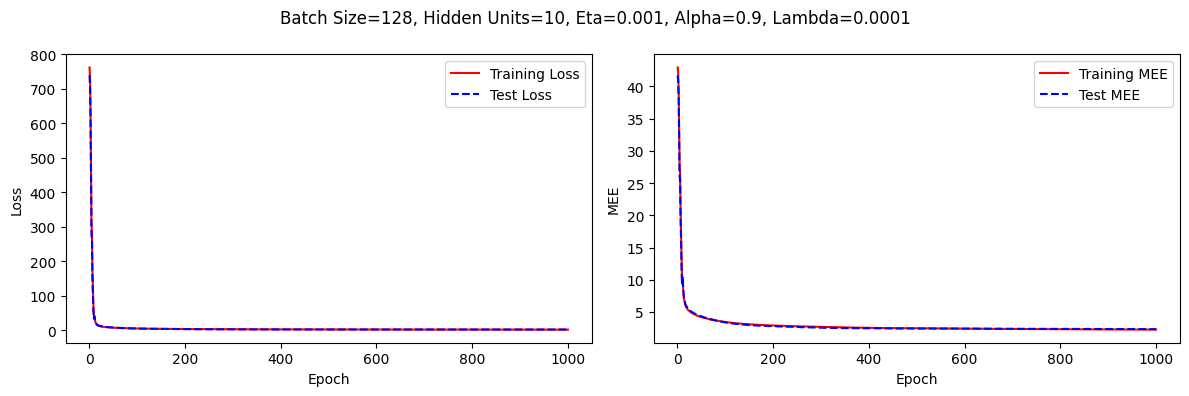

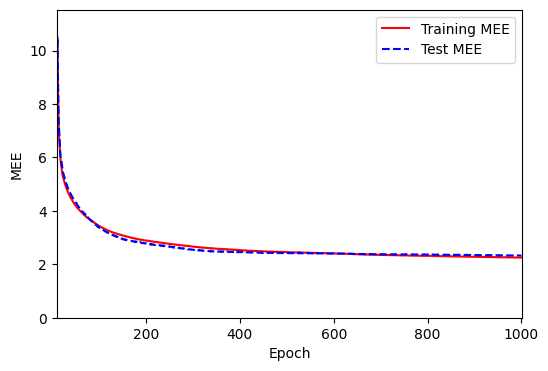

Training - Epoch [1000/1000], Loss: 2.3878, MEE: 2.3283 | Test - Epoch [1000/1000], Loss: 3.0224 MEE: 2.5429 
 N. Epochs = 1000 - Loss (train | test)= (2.388 | 3.022) - MEE (train | test) = (2.3283419609069824 | 2.5428974628448486)


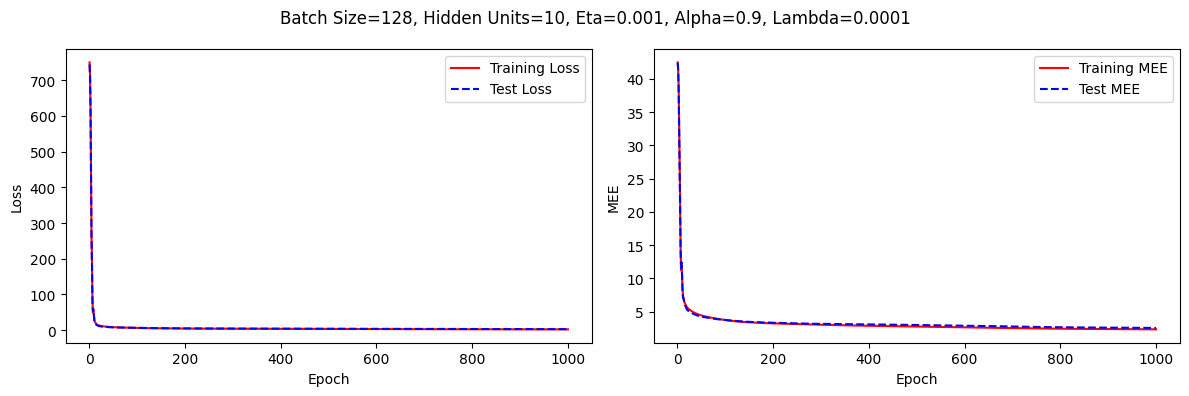

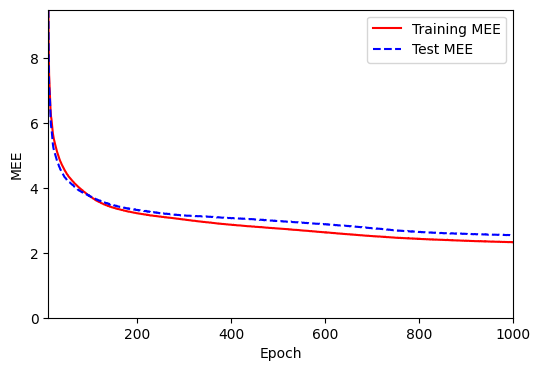

Training - Epoch [1000/1000], Loss: 2.1219, MEE: 2.1806 | Test - Epoch [1000/1000], Loss: 2.4839 MEE: 2.2875 
 N. Epochs = 1000 - Loss (train | test)= (2.122 | 2.484) - MEE (train | test) = (2.1805872917175293 | 2.2874755859375)


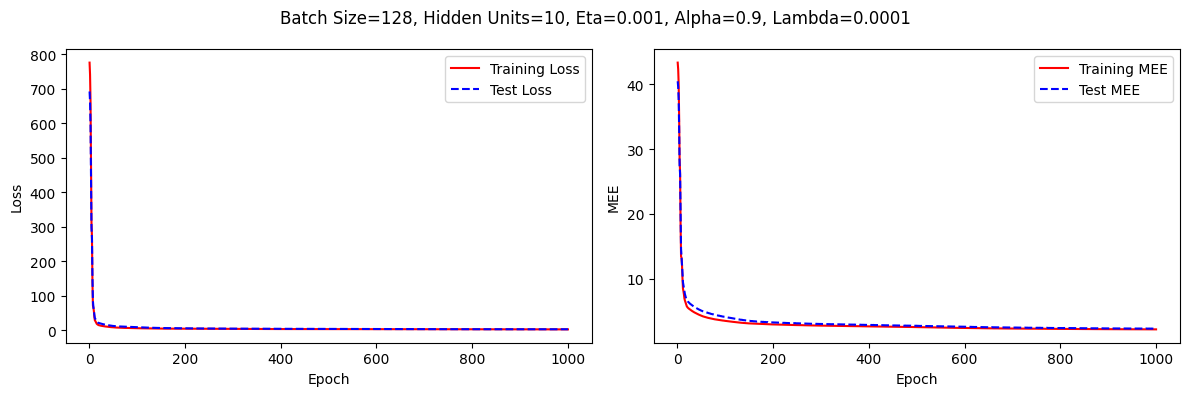

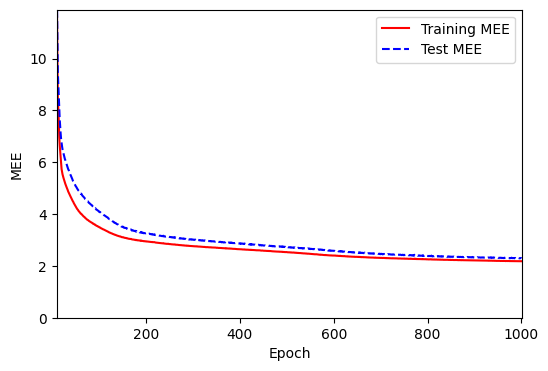

Training - Epoch [1000/1000], Loss: 2.2138, MEE: 2.2231 | Test - Epoch [1000/1000], Loss: 3.1420 MEE: 2.6085 
 N. Epochs = 1000 - Loss (train | test)= (2.214 | 3.142) - MEE (train | test) = (2.2230966091156006 | 2.6085281372070312)


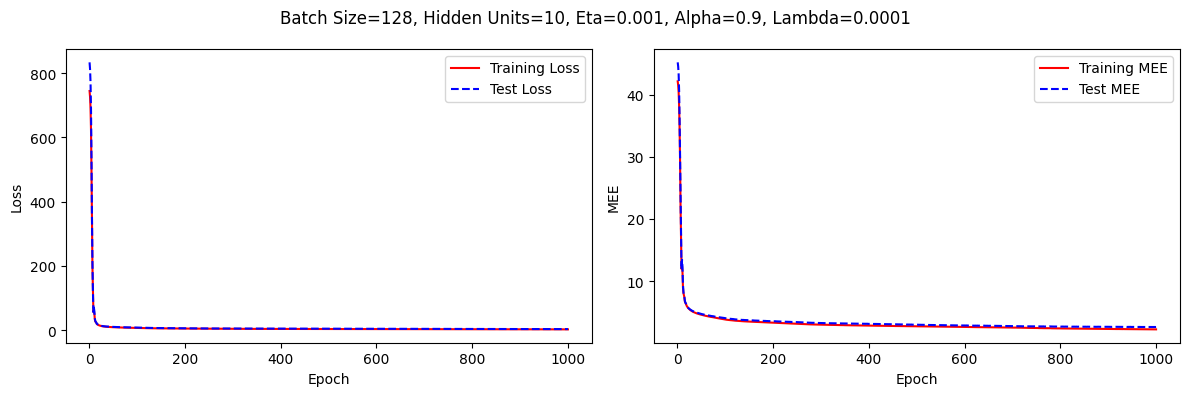

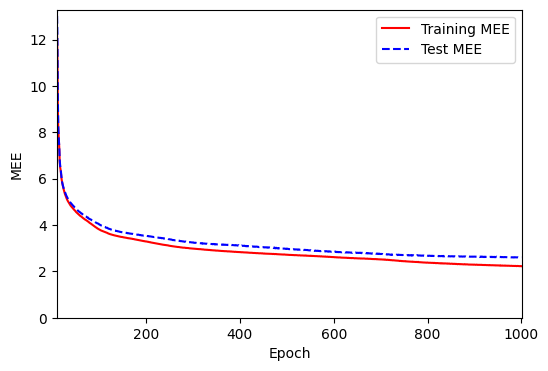

Training - Epoch [1000/1000], Loss: 2.4172, MEE: 2.3583 | Test - Epoch [1000/1000], Loss: 3.1553 MEE: 2.7105 
 N. Epochs = 1000 - Loss (train | test)= (2.417 | 3.155) - MEE (train | test) = (2.3582630157470703 | 2.710512161254883)


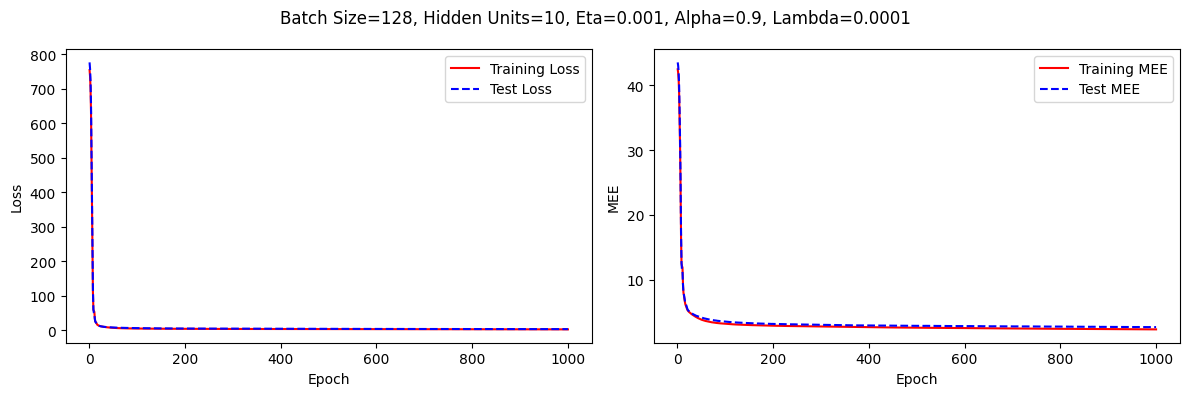

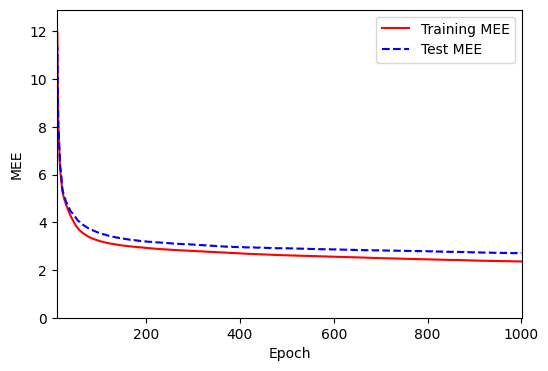

Final Results: hidden_size=10; lr=0.001; alpha = 0.9; batch size = 128; lambda = 0.0001 --> train_loss = 2.265 +- 0.1162 | val_loss = 2.837 +- 0.335train_mee = 2.269 +- 0.06583 | val_mee = 2.495 +- 0.1634
[10, 0.001, 0.9, 128, 0.0001]


In [202]:
hidden_sizes = [10]
learning_rates = [0.001]
momentums = [0.9]
batch_sizes = [128]
reg_coeffs = [1e-4]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=X_train,
                                    y=y_train,
                                    plot_curves=True)

In [203]:
train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [1000/1000], Loss: 1.5481, MEE: 1.8403 | Test - Epoch [1000/1000], Loss: 2.1780 MEE: 2.1759 
 N. Epochs = 1000 - Loss (train | test)= (1.548 | 2.178) - MEE (train | test) = (1.8403151035308838 | 2.1759133338928223)
Training - Epoch [1000/1000], Loss: 1.8663, MEE: 2.0377 | Test - Epoch [1000/1000], Loss: 1.9583 MEE: 2.1024 
 N. Epochs = 1000 - Loss (train | test)= (1.866 | 1.958) - MEE (train | test) = (2.037693738937378 | 2.1024374961853027)
Training - Epoch [1000/1000], Loss: 1.8145, MEE: 2.0356 | Test - Epoch [1000/1000], Loss: 2.1822 MEE: 2.2096 
 N. Epochs = 1000 - Loss (train | test)= (1.814 | 2.182) - MEE (train | test) = (2.0356054306030273 | 2.2096331119537354)
Training - Epoch [1000/1000], Loss: 1.6024, MEE: 1.9003 | Test - Epoch [1000/1000], Loss: 1.7897 MEE: 1.9935 
 N. Epochs = 1000 - Loss (train | test)= (1.602 | 1.79) - MEE (train | test) = (1.9002877473831177 | 1.9934875965118408)
Training - Epoch [1000/1000], Loss: 1.9504, MEE: 2.1217 | Test - Epoch [10

Training - Epoch [1000/1000], Loss: 2.0142, MEE: 2.1404 | Test - Epoch [1000/1000], Loss: 2.8185 MEE: 2.4496 
 N. Epochs = 1000 - Loss (train | test)= (2.014 | 2.819) - MEE (train | test) = (2.140441417694092 | 2.449638843536377)


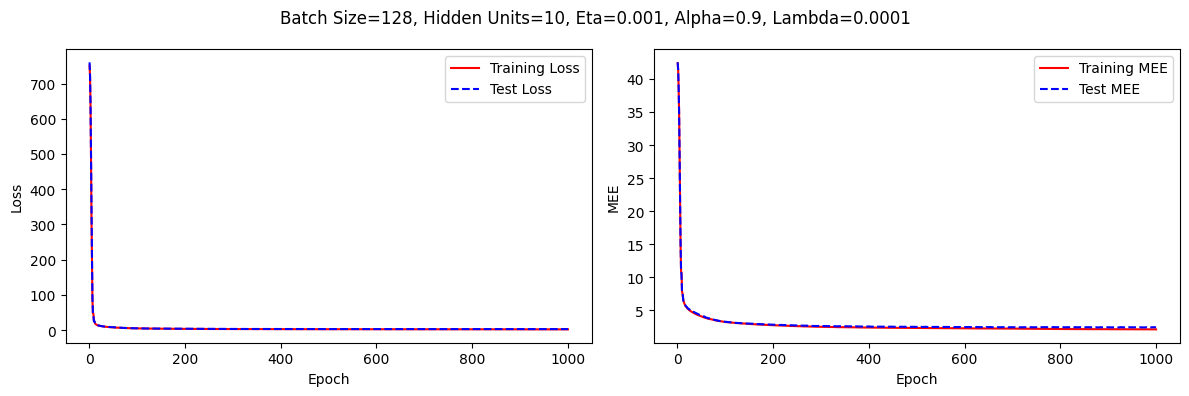

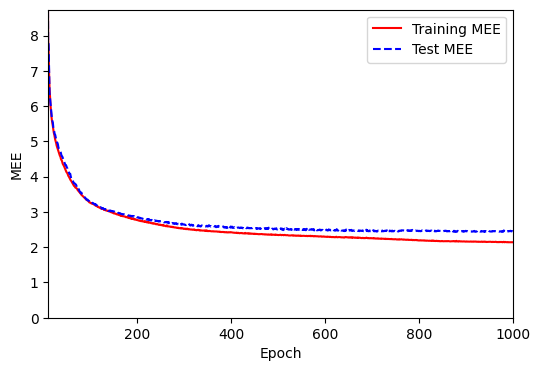

(1000,
 2.014150857925415,
 2.8185484409332275,
 2.140441417694092,
 2.449638843536377)

In [204]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)